In [36]:
from pathlib import Path
import pandas as pd
import json
import pickle
import warnings

from tqdm import tqdm
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.statistics import TTest, gaussian_sigma_2_fpf, fpf_2_gaussian_sigma
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.photometry import AperturePhotometryMode
from applefy.utils.file_handling import save_as_fits
from applefy.utils.contrast_grid import compute_contrast_from_grid

from fours.utils.data_handling import read_fours_root_dir
from fours.utils.setups import contrast_grid_setup_1
from fours.detection_limits.applefy_wrapper import CADIDataReductionGPU, PCADataReductionGPU
from fours.detection_limits.applefy_wrapper import FourSDataReduction
from fours.models.psf_subtraction import FourS

# Load the dataset

In [37]:
# Datasets
datasets = [
    "HD2262_305_199_C-0065_C_", #1
    "HD7570_331_1101_C-0092_C_", #2
    "HD11171_332_1101_C-0092_C_", #3
    "HD22049_351_096_C-0679_A_", #4
    "HD22049_303_199_C-0065_C_", #5
    "HD38678_331_084_C-0396_A_", #6
    "HD40136_333_1101_C-0092_C_", #7
    "HD115892_143_1101_C-0092_E_", #8
    "HD169022_140_1101_C-0092_E_", #9
    "HD177724_231_091_C-0654_A_", #10
    "HD209952_196_089_C-0149_A_", #11
]

In [38]:
dataset_name = datasets[0]
root_dir = Path("/fast/mbonse/s4")
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

In [39]:
dataset_name

'HD2262_305_199_C-0065_C_'

In [40]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [41]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [42]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [43]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [44]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# Run fake planet experiments for 4S

In [45]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor, # A factor to account e.g. for ND filters
    checkpoint_dir=experiment_root_dir)

In [46]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)
print("Brightness of fake planets in mag: " + str(flux_ratio2mag(flux_ratios)))
print("Separations of interest in lambda /D: " + str(separations / fwhm))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 15. ]
Separations of interest in lambda /D: [ 1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.
 12. ]


In [47]:
print("# Grid experiments: " + str(len(separations) * len(flux_ratios) * num_fake_planets))

# Grid experiments: 945


In [48]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


In [50]:
for lambda_reg, special_name in [
    (100, "lambda_000100"),
    (1000, "lambda_001000"),
    (10000, "lambda_010000"),
    (100000, "lambda_100000")]:

    s4_model = FourSDataReduction(
        device="cpu",
        lambda_reg=lambda_reg,
        psf_fwhm=fwhm,
        right_reason_mask_factor=1.5,
        rotation_grid_down_sample=1,
        logging_interval=50,
        save_models=True,
        train_num_epochs=500,
        special_name=special_name,
        work_dir=None,
        verbose=False)

    old_results = contrast_instance.results_dict
    contrast_instance.run_fake_planet_experiments(
        algorithm_function=s4_model,
        num_parallel=1)
    contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:01<00:00, 680.66it/s]


[DONE]
Running fake planet experiments...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:14<00:00, 65.87it/s]


[DONE]
Running fake planet experiments...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:14<00:00, 64.84it/s]


[DONE]
Running fake planet experiments...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 937/946 [00:15<00:00, 50.97it/s]

# compute the throughput

In [51]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2)

In [52]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [53]:
contrast_results_1 = contrast_instance.contrast_results["s4_mean_lambda_010000"]

In [54]:
throughput_results_1 = contrast_results_1.compute_throughput().T

# Create the plot

In [55]:
throughput_results_1.index = flux_ratio2mag(throughput_results_1.index)
throughput_results_1.columns = (throughput_results_1.columns/3.6).astype("int")

In [56]:
def plot_throughput(axis_in,
                    tmp_throughput_results,
                    color_bar):

    c_bar_kargs = dict(orientation = "vertical",
                       label = r"Throughput - $\kappa(f_p, s)$")

    heat = sns.heatmap(tmp_throughput_results,
                       vmax=0, vmin=0.8,
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       cbar_ax=colorbar_ax,
                       cbar_kws=c_bar_kargs)

    ylabels = ['{:d}'.format(int(float(x.get_text()))) for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

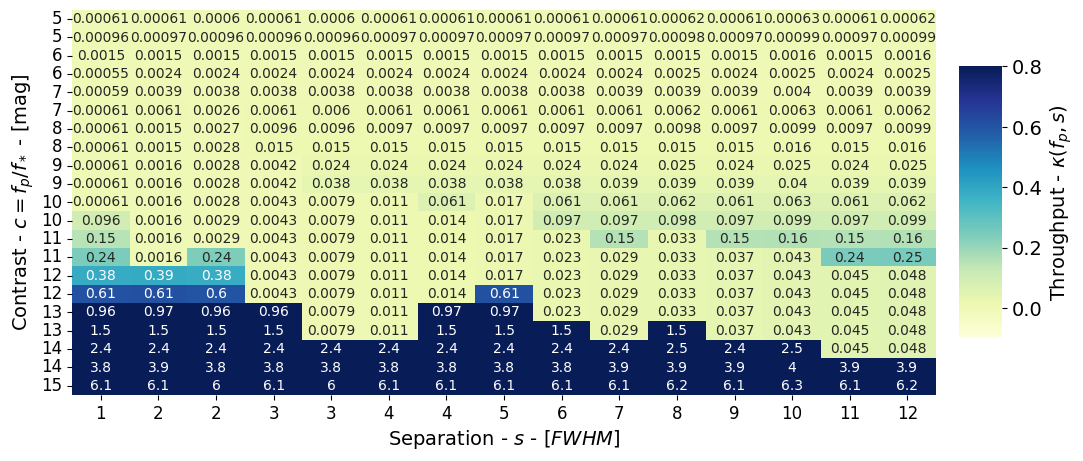

In [58]:
# 1. Create the plot layout ---------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(12, 5))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 0.05])
gs0.update(wspace=0.05)

gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 1, subplot_spec = gs0[0],
    hspace=0.12)
gs2 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec = gs0[1],
    height_ratios=[0.1, 0.8, 0.1])

throughput_ax1 = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs2[1])

# 2. Plot the throughput table ------------------------------------
plot_throughput(throughput_ax1, throughput_results_1,
                color_bar=False)

throughput_ax1.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(None)
throughput_ax1.tick_params(
    axis='both', which='major', labelsize=12)

# 3. Create the colorbar ------------------------------------------
cbar = throughput_ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
throughput_ax1.figure.axes[-1].yaxis.label.set_size(14)

# 4. Labels -------------------------------------------------------
throughput_ax1.set_ylabel(
    r"Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(
    r"Separation - $s$ - $\left[FWHM \right]$", size=14)

fig.patch.set_facecolor('white')
#plt.savefig("./12_Throughput.pdf", bbox_inches='tight')

In [69]:
idx_table = contrast_results_1.idx_table.copy().T

In [70]:
idx_table.index = flux_ratio2mag(idx_table.index)
idx_table.columns = (idx_table.columns/3.6).astype("int")

In [71]:
idx_table

separation,1,2,2,3,3,4,4,5,6,7,8,9,10,11,12
flux_ratio,,,,,,,,,,,,,,,
5.0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
5.5,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
6.0,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
6.5,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
7.0,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
7.5,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
8.0,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
8.5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
9.0,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
